In [29]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
/gdrive


In [ ]:
print("Testing")

In [30]:
ls

MyDrive/  Shareddrives/


In [31]:
cd/gdrive/MyDrive/Seismic Classification/

/gdrive/MyDrive/Seismic Classification


In [32]:
ls

 anticline/   fault/   salt/  'Seismic Classification.h5'


In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [34]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [35]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=40
CHANNELS=3

In [36]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Seismic Classification",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 206 files belonging to 3 classes.


In [37]:
class_names = dataset.class_names
class_names

['anticline', 'fault', 'salt']

In [38]:
len(dataset)

4

In [39]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[193.       181.       133.      ]
  [196.34961  185.30664  136.82812 ]
  [198.03711  187.90625  139.42969 ]
  ...
  [111.71094  110.71094  115.8418  ]
  [114.822266 113.822266 118.822266]
  [122.       121.       126.      ]]

 [[194.09375  181.54688  133.82031 ]
  [197.83589  186.1152   138.30266 ]
  [199.87961  188.96422  141.43828 ]
  ...
  [ 97.43344   95.68469   99.68602 ]
  [101.470825  99.65051  103.271576]
  [109.69531  107.875    111.234375]]

 [[196.15625  182.57812  135.36719 ]
  [200.6386   187.63992  141.0832  ]
  [203.35403  190.95924  145.2259  ]
  ...
  [ 70.51016   67.34949   69.22084 ]
  [ 76.29382   72.926636  73.94742 ]
  [ 86.49219   83.125     83.390625]]

 ...

 [[176.6875   174.6875   158.42188 ]
  [176.58656  174.58656  158.32094 ]
  [176.27005  174.3733   157.7427  ]
  ...
  [195.0017   177.71289  119.07565 ]
  [195.09187  176.1693   115.427185]
  [194.78906  174.63281  113.109375]]

 [[180.8125   178.8125   159.45312 ]
  [180.4

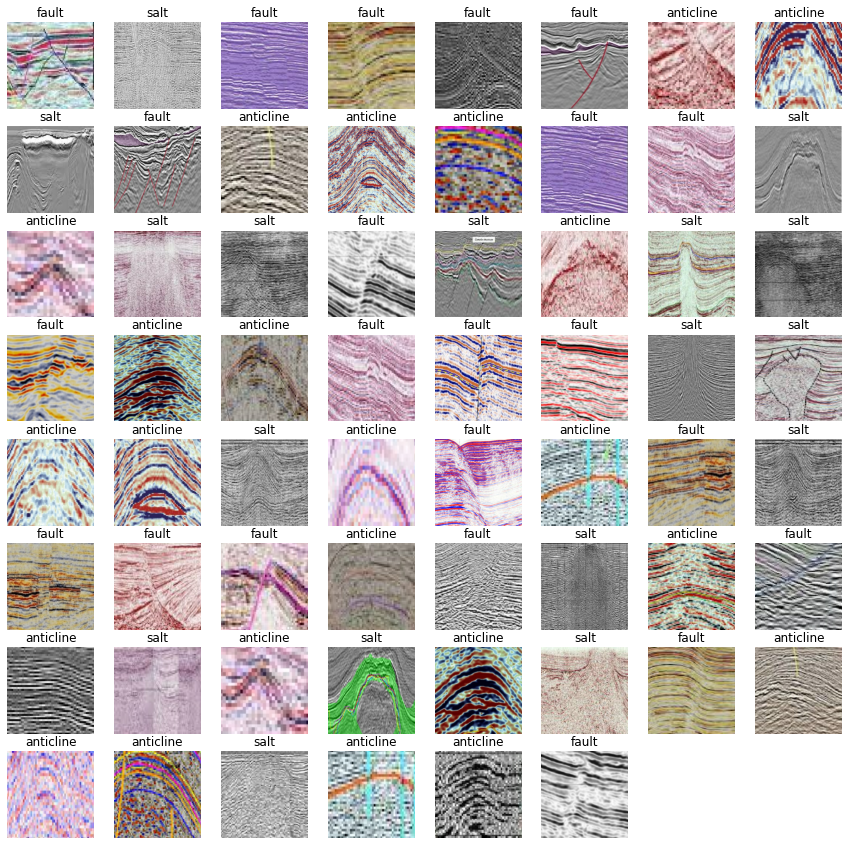

In [40]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [41]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [42]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [43]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [44]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (62, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (62, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (62, 60, 60, 64)         

In [48]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/40
3/3 [==============================] - 17s 4s/step - loss: 2.1413 - accuracy: 0.1875
Epoch 2/40
3/3 [==============================] - 18s 6s/step - loss: 1.5761 - accuracy: 0.3333
Epoch 3/40
3/3 [==============================] - 16s 4s/step - loss: 1.2004 - accuracy: 0.3472
Epoch 4/40
3/3 [==============================] - 16s 4s/step - loss: 1.1383 - accuracy: 0.3681
Epoch 5/40
3/3 [==============================] - 16s 7s/step - loss: 1.1133 - accuracy: 0.3681
Epoch 6/40
3/3 [==============================] - 16s 4s/step - loss: 1.1268 - accuracy: 0.2986
Epoch 7/40
3/3 [==============================] - 15s 4s/step - loss: 1.1140 - accuracy: 0.3542
Epoch 8/40
3/3 [==============================] - 16s 4s/step - loss: 1.1121 - accuracy: 0.3681
Epoch 9/40
3/3 [==============================] - 16s 7s/step - loss: 1.1161 - accuracy: 0.3681
Epoch 10/40
3/3 [==============================] - 16s 7s/step - loss: 1.0986 - accuracy: 0.4306
Epoch 11/40
3/3 [======================

In [49]:
model.evaluate(test_ds)

1/1 [==============================] - 3s 3s/step - loss: 0.6112 - accuracy: 0.8226


[0.6111795902252197, 0.8225806355476379]

In [50]:
acc = history.history['accuracy']
loss = history.history['loss']

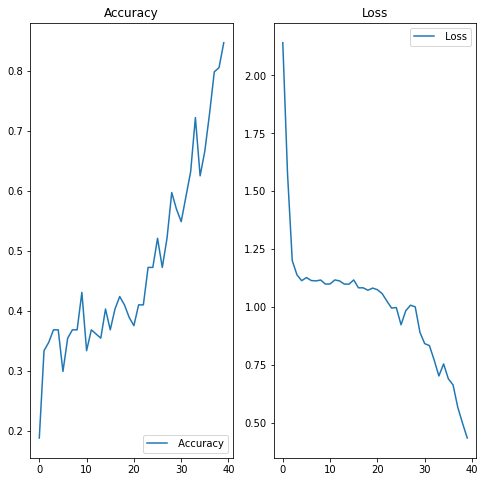

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

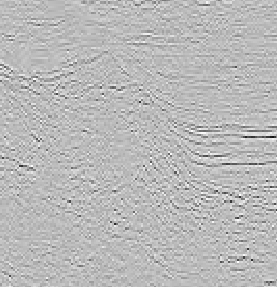

In [52]:
image_path = "/gdrive/My Drive/2020-07-24 22_14_54-images (33) - Windows Photo Viewer.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [53]:
pred = model.predict(scaled_img)

In [54]:
output = class_names[np.argmax(pred)]

In [55]:
output

'salt'

In [56]:
model.save("Seismic Classification.h5")